In [2]:
import pygad
import networkx as nx
import numpy as np
import tnetwork as tn
from tqdm import tqdm

import random
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import os, sys
sys.path.append(os.getcwd() + "/../")
from visualize_communities.amalgamate import amalgamate
import scipy.stats as stats

import Levenshtein as levenshtein

from sklearn.metrics import normalized_mutual_info_score as nmi

from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.model_selection import RandomizedSearchCV



In [3]:
G = nx.Graph()
n = 256
G.add_nodes_from(range(n))

avg_degree = 24
clusters = 8

timesteps = 50

def initialize_ground_truth():
    ground_truth = {i: {} for i in range(timesteps)}
    for i in range(n):
        ground_truth[0][i] = (i // (n // clusters))
    return ground_truth

ground_truth = initialize_ground_truth()

z = 8
p_out = z / ((n - n // clusters)) 
p_in = (avg_degree - (n - n // clusters) * p_out) / (n // clusters)

def sample_edges(i, t, init=False):
    for j in range(n):
        if i == j or (init and i > j):
            continue

        if ground_truth[t][i] == ground_truth[t][j] and np.random.random() < p_in:
            G.add_edge(i, j)
        elif np.random.random() < p_out:
            G.add_edge(i, j)

for i in range(n):
    sample_edges(i, 0, init=True)

print("avg degree", np.mean(list(dict(G.degree()).values())))

DG = tn.DynGraphSN()
DG.add_snapshot(0, G)

nc = 0.3
ground_truth = initialize_ground_truth()


for t in range(1, 100):
    G = DG.snapshots(t-1).copy()
    ground_truth[t] = ground_truth[t - 1].copy()

    move_nodes = random.sample(list(G.nodes()), int(nc * n))
    
    for node in move_nodes:
        new_community = random.sample([i for i in range(clusters) if i != ground_truth[t][node]], 1)[0]
        ground_truth[t][node] = new_community
        G.remove_edges_from(list(G.edges(node)))
        sample_edges(node, t)

    DG.add_snapshot(t, G)

avg degree 23.8046875


In [4]:
def stupid_louvain(DG):
    communities = tn.DynCommunitiesSN()
    for t in tqdm(DG.snapshots_timesteps()):
        coms = nx.community.louvain_communities(DG.snapshots(t))
        coms = {i: list(c) for i, c in enumerate(coms)}
        communities.set_communities(t, coms)
    return communities

stupid_louvain_coms = stupid_louvain(DG)
print(stupid_louvain_coms.snapshots[1])

100%|██████████| 100/100 [00:03<00:00, 28.78it/s]

{0: [1, 12, 146, 154, 29, 85, 88, 95, 96, 97, 100, 101, 102, 104, 105, 107, 108, 109, 110, 111, 112, 113, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127], 1: [129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 147, 149, 151, 153, 27, 156, 158, 50, 67, 200, 209, 213, 87, 222, 103, 237, 114, 118], 2: [73, 203, 16, 18, 160, 161, 162, 163, 164, 165, 166, 167, 186, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 185, 58, 187, 188, 189, 190], 3: [0, 2, 194, 3, 6, 7, 8, 9, 10, 11, 15, 81, 17, 19, 145, 20, 22, 23, 25, 157, 30, 31, 99, 49, 115, 116, 183], 4: [192, 4, 197, 198, 199, 196, 201, 202, 204, 205, 206, 207, 210, 215, 216, 217, 218, 91, 219, 221, 220, 159, 32, 230, 44, 46, 181, 184], 5: [64, 65, 66, 195, 68, 69, 70, 71, 72, 74, 75, 76, 13, 77, 79, 78, 80, 82, 83, 84, 212, 214, 86, 155, 92, 93, 94, 106, 57], 6: [142, 14, 148, 21, 24, 26, 33, 34, 35, 36, 37, 39, 40, 41, 168, 43, 42, 45, 47, 48, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 208, 211, 89, 223,

In [5]:
def flip_partitioning(partitioning):
    nodes = [item for sublist in partitioning.values() for item in sublist]
    return dict(zip(nodes, map(lambda x: next(int(k) for k in partitioning.keys() if x in partitioning[k]), nodes)))


In [6]:
def unflip_partitioning(partitioning):
    return {i: [k for k, v in partitioning.items() if v == i] for i in set(partitioning.values())}

In [7]:
def amalgamate_stupid_louvain(DG):
    communities = stupid_louvain(DG)
    snapshots = []
    for t in communities.snapshots_timesteps():
        snapshot = communities.snapshots[t]
        flipped = flip_partitioning(snapshot)
        # print(flipped)
        snapshots.append(flipped)
    df = pd.DataFrame.from_dict(snapshots).transpose()
    df.sort_index(inplace=True)
    df.rename(columns={c: f"c{c}" for c in df.columns}, inplace=True)
    amalgamated = amalgamate(df, 1, 100)
    new_communities = tn.DynCommunitiesSN()
    for t in communities.snapshots_timesteps():
        snapshot = amalgamated[f"c{t}"].to_dict()
        coms = {i: [k for k, v in snapshot.items() if v == i] for i in set(snapshot.values())}
        new_communities.set_communities(t, coms)
    return new_communities

P = amalgamate_stupid_louvain(DG)

100%|██████████| 100/100 [00:03<00:00, 30.74it/s]


In [8]:
def estrangement(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)
    estranged = 0

    G1edges = G1.edges()

    for edge in G2.edges():
        if edge not in G1edges:
            # edges that are not in G1 are not estranged
            continue
        if C1[edge[0]] != C1[edge[1]]:
            # only edges that connected nodes in the same community can be estranged
            continue
        if C2[edge[0]] != C2[edge[1]]:
            estranged += 1
    if len(G2.edges()) == 0:
        return np.nan
    return estranged / len(G2.edges())


In [9]:
def levenshtein_distance(G1, G2, C1, C2):

    # get values sorted by key
    a = [C1[k] for k in sorted(C1.keys())]
    b = [C2[k] for k in sorted(C2.keys())]

    if min(len(a), len(b)) == 0:
        return np.nan

    return levenshtein.distance(a, b) / max(len(a), len(b))


In [10]:
SC = lambda G, P: nx.algorithms.community.modularity(G, list(unflip_partitioning(P).values()))  # modularity scoral cost
# TC = lambda G1, G2, C1, C2: 1 - estrangement(G1, G2, unflip_partitioning(C1), unflip_partitioning(C2))  # estrangement temporal cost
# TC = lambda G1, G2, C1, C2: nmi(list(C1.values()), list(C2.values()))
TC = lambda G1, G2, C1, C2: 1 - levenshtein_distance(G1, G2, C1, C2)

G1 = DG.snapshots(0)
G2 = DG.snapshots(1)

P1 = flip_partitioning(P.snapshots[0])
P2 = flip_partitioning(P.snapshots[1])

P1 = dict(sorted(P1.items()))
P2 = dict(sorted(P2.items()))

In [30]:
# y = f(w1:w6) = w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + w6x6
# where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7) and y=44

alpha = 0.5

def apply_solution(G, solution, P_old, P_new):
    P_updated = P_new.copy()
    for i in range(len(solution)):
        if solution[i] == 1:
            P_updated[i] = P_old[i]
    return dict(sorted(P_updated.items()))

def fitness_func(ga_instance, solution, solution_idx):
    # G2_prime = G2.copy()
    P2_prime = apply_solution(G2, solution, P1, P2)

    sc = SC(G2, P2_prime)
    tc = TC(G1, G2, P1, P2_prime)

    # fitness = sc ** alpha * tc ** (1 - alpha)
    fitness = alpha * sc + (1 - alpha) * tc
    # fitness = 1.0 / cost
    return fitness

In [34]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 4

sol_per_pop = 16
num_genes = len(G1.nodes())

# Binary encoding
init_range_low = 0
init_range_high = 2
gene_type = int

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"  # maybe try adaptive?
mutation_percent_genes = 20

In [49]:
def ga_best_solution(**kwargs):
    # with tqdm(total=num_generations) as pbar:
    ga_instance = pygad.GA(num_generations=num_generations,
                    fitness_func=fitness_function,
                    gene_type=gene_type,
                    num_genes=num_genes,
                    init_range_low=init_range_low,
                    init_range_high=init_range_high,
                    # on_generation=lambda _: pbar.update(1),
                    **kwargs)
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    return solution, solution_fitness, solution_idx, ga_instance

In [50]:
def ga_fitness(**kwargs):
    solution, solution_fitness, solution_idx, ga_instance = ga_best_solution(**kwargs)
    return solution_fitness

In [51]:
params = {
    "keep_elitism": 3,
    "num_parents_mating": 8,
    "sol_per_pop": 20,
    "crossover_type": "single_point",
    "parent_selection_type": "rank",
    "keep_elitism": 2,
    "mutation_type": "random",
    "keep_parents": 3,
    "mutation_percent_genes": 30,
}

solution, solution_fitness, solution_idx, ga_instance = ga_best_solution(**params)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness of original solution : {original_fitness}".format(original_fitness=fitness_function(ga_instance, [0] * len(solution), 0)))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

# prediction = np.sum(np.array(function_inputs)*solution)
# print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitness of original solution : 0.6296356816496406
Fitness value of the best solution = 0.632794575781766


In [52]:
P_updated = apply_solution(G2, solution, P1, P2)

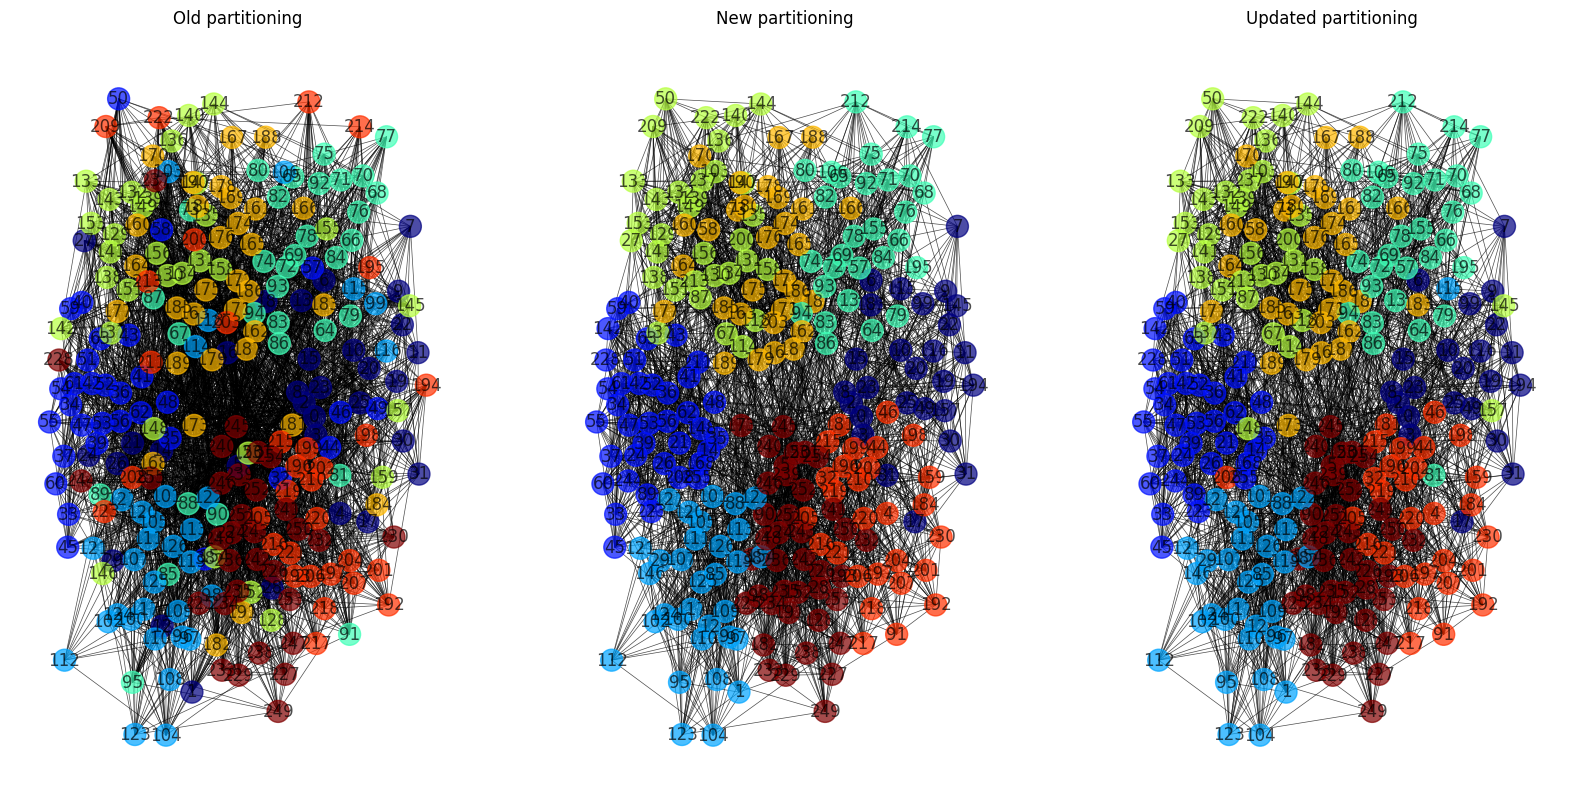

In [53]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta', 'black']
pos = nx.spring_layout(G2)
nx.draw(G1, pos=pos, node_color=list(P1.values()), cmap=plt.cm.jet, node_size=250, alpha=0.7, with_labels=True, width=0.5, ax=ax0)
ax0.set_title("Old partitioning")
nx.draw(G2, pos=pos, node_color=list(P2.values()), cmap=plt.cm.jet, node_size=250, alpha=0.7, with_labels=True, width=0.5, ax=ax1)
ax1.set_title("New partitioning")
nx.draw(G2, pos=pos, node_color=list(P_updated.values()), cmap=plt.cm.jet, node_size=250, alpha=0.7, with_labels=True, width=0.5, ax=ax2)
ax2.set_title("Updated partitioning")
plt.show()

In [54]:
print(f"SC P2: {SC(G2, P2)}")
print(f"SC P_updated: {SC(G2, P_updated)}")

print(f"TC P1 vs P2: {TC(G1, G2, P1, P2)}")
print(f"TC P1 vs P_updated {TC(G1, G2, P1, P_updated)}")

SC P2: 0.5561463632992811
SC P_updated: 0.531214151563532
TC P1 vs P2: 0.703125
TC P1 vs P_updated 0.734375


In [55]:
ground = {a: b for a, b in sorted(ground_truth[1].items(), key=lambda x: x[0])}
print(ground)
print(P2)
print(P_updated)
(TC(G1, G2, ground, P2), TC(G1, G2, ground, P_updated))

{0: 0, 1: 3, 2: 0, 3: 0, 4: 6, 5: 7, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 3, 13: 2, 14: 1, 15: 0, 16: 5, 17: 0, 18: 5, 19: 0, 20: 0, 21: 1, 22: 0, 23: 0, 24: 1, 25: 0, 26: 1, 27: 4, 28: 7, 29: 3, 30: 0, 31: 0, 32: 6, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 7, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 6, 45: 1, 46: 6, 47: 1, 48: 1, 49: 0, 50: 4, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 2, 58: 5, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 2, 65: 2, 66: 2, 67: 4, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 5, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 0, 82: 2, 83: 2, 84: 2, 85: 3, 86: 2, 87: 4, 88: 3, 89: 1, 90: 7, 91: 6, 92: 2, 93: 2, 94: 2, 95: 3, 96: 3, 97: 3, 98: 7, 99: 0, 100: 3, 101: 3, 102: 3, 103: 4, 104: 3, 105: 3, 106: 2, 107: 3, 108: 3, 109: 3, 110: 3, 111: 3, 112: 3, 113: 3, 114: 4, 115: 0, 116: 0, 117: 3, 118: 4, 119: 3, 120: 3, 121: 3, 122: 3, 123: 3, 124: 3, 125: 3, 126: 3, 127: 3, 128: 7, 129: 4, 130: 4, 131: 4, 132: 4, 133: 4, 134: 4, 135: 4, 136: 4, 137: 4, 138: 

(0.76953125, 0.73828125)

In [65]:
# plot percentages

# table, avg, max, min, std over time

# mod gain plot
# stability gain plot
# 

mutation_types = ["random", "swap", "scramble", "inversion"]
crossover_types = ["single_point", "two_points", "uniform", "scattered"]
parent_selection_types = ["rws", "sus", "rank", "random", "tournament"]

def validate_params(params):

    if params["num_parents_mating"] > params["sol_per_pop"]:
        return False
    if params["keep_parents"] > params["num_parents_mating"] or params["keep_parents"] > params["sol_per_pop"]:
        return False
    if params["keep_elitism"] > params["sol_per_pop"]:
        return False
    return True


def discretize_params(**kwargs):
    keep_elitism = int(kwargs["keep_elitism"])
    num_parents_mating = int(kwargs["num_parents_mating"])
    sol_per_pop = int(kwargs["sol_per_pop"])
    keep_parents = int(kwargs["keep_parents"])

    parent_selection_type = parent_selection_types[int(kwargs["parent_selection_type"])]
    crossover_type = crossover_types[int(kwargs["crossover_type"])]

    mutation_type = mutation_types[int(kwargs["mutation_type"])]
    mutation_percent_genes = kwargs["mutation_percent_genes"]

    if not validate_params(locals()):
        return None, False

    return {
        "keep_elitism": keep_elitism,
        "num_parents_mating": num_parents_mating,
        "sol_per_pop": sol_per_pop,
        "keep_parents": keep_parents,
        "parent_selection_type": parent_selection_type,
        "crossover_type": crossover_type,
        "mutation_type": mutation_type,
        "mutation_percent_genes": mutation_percent_genes
    }, True


eps = 1e-10
pbounds = {
    "keep_elitism": (0, 10),
    "num_parents_mating": (1, 14),
    "sol_per_pop": (1, 100),
    "crossover_type": (0, len(crossover_types) - eps),
    "parent_selection_type": (0, len(parent_selection_types) - eps),
    "keep_elitism": (0, 10),
    "mutation_type": (0, len(mutation_types) - eps),
    "keep_parents": (0, 10),
    "mutation_percent_genes": (1, 100),
}

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

def discrete_run_ga(**kwargs):
    discrete_params, valid = discretize_params(**kwargs)
    if not valid:
        return 0
    return ga_fitness(**discrete_params)


optimizer = BayesianOptimization(
    f=discrete_run_ga,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [67]:
# for i in range(4):
#     next_point = optimizer.suggest(utility)
#     target = discrete_run_ga(**next_point)
#     optimizer.register(params=next_point, target=target)

#     print(i, target, next_point)
# print(optimizer.max)

optimizer.maximize(
    init_points=5,
    n_iter=20,
)


|   iter    |  target   | crosso... | keep_e... | keep_p... | mutati... | mutati... | num_pa... | parent... | sol_pe... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6312    | 1.587     | 5.388     | 4.192     | 68.84     | 0.8178    | 12.42     | 0.1369    | 67.38     |
| 2         | 0.6316    | 1.669     | 5.587     | 1.404     | 20.61     | 3.203     | 13.59     | 1.567     | 69.54     |
| 3         | 0.6334    | 3.506     | 8.946     | 0.8504    | 4.866     | 0.6793    | 12.42     | 0.4917    | 42.69     |
| 4         | 0.6309    | 3.832     | 5.332     | 6.919     | 32.24     | 2.746     | 11.85     | 0.09144   | 75.26     |
| 5         | 0.6318    | 3.955     | 7.482     | 2.804     | 79.14     | 0.4129    | 6.823     | 4.543     | 30.07     |
| 6         | 0.6302    | 1.151     | 1.3       | 0.1937    | 68.2      | 0.8465    | 4.452     | 2.458     | 6.283     |
| 7         | 0.631     

In [64]:
optimizer.max

{'target': 0.6330973725598333,
 'params': {'crossover_type': 3.2217763637487926,
  'keep_elitism': 1.5178705428337202,
  'keep_parents': 3.2373809588514435,
  'mutation_percent_genes': 43.78746257028148,
  'mutation_type': 3.8368835754247277,
  'num_parents_mating': 9.416225399612994,
  'parent_selection_type': 2.7199224516655875,
  'sol_per_pop': 37.95582117137243}}

In [ ]:
class OwnEstimator():
    def __init__(self,**kwargs):
        self.params = kwargs
 
    def fit(self, X, y):
        return self

    def set_params(self,**kwargs):
        self.params = kwargs
        return self

    def get_params(self,deep=True):
        return self.params.copy()

    def predict(self,X):
        if not validate_params(self.params):
            return 0
        return run_ga(**self.params)

    def score(self,X, y):
        return self.predict(X)

In [ ]:
pbounds = {
    "keep_elitism": range(11),
    "num_parents_mating": range(1, 11),
    "sol_per_pop": range(1, 21),
    "crossover_type": crossover_types,
    "parent_selection_type": parent_selection_types,
    "keep_elitism": range(0, 11),
    "mutation_type": mutation_types,
    "keep_parents": range(11),
    "mutation_type": mutation_types,
    "mutation_percent_genes": stats.uniform(0, 100),
}

my_model = OwnEstimator()

searcher = RandomizedSearchCV(my_model, pbounds, n_iter=100, verbose=2)

In [ ]:
searcher.fit([None] * 10, [None] * 10)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END crossover_type=single_point, keep_elitism=1, keep_parents=3, mutation_percent_genes=56.12211961299456, mutation_type=swap, num_parents_mating=3, parent_selection_type=rank, sol_per_pop=15; total time=   0.0s
[CV] END crossover_type=single_point, keep_elitism=1, keep_parents=3, mutation_percent_genes=56.12211961299456, mutation_type=swap, num_parents_mating=3, parent_selection_type=rank, sol_per_pop=15; total time=   0.0s
[CV] END crossover_type=single_point, keep_elitism=1, keep_parents=3, mutation_percent_genes=56.12211961299456, mutation_type=swap, num_parents_mating=3, parent_selection_type=rank, sol_per_pop=15; total time=   0.0s
[CV] END crossover_type=single_point, keep_elitism=1, keep_parents=3, mutation_percent_genes=56.12211961299456, mutation_type=swap, num_parents_mating=3, parent_selection_type=rank, sol_per_pop=15; total time=   0.0s
[CV] END crossover_type=single_point, keep_elitism=1, keep_parents=3,

RandomizedSearchCV(estimator=<__main__.OwnEstimator object at 0x7f794976fdf0>,
                   n_iter=100,
                   param_distributions={'crossover_type': ['single_point',
                                                           'two_points',
                                                           'uniform',
                                                           'scattered'],
                                        'keep_elitism': range(0, 11),
                                        'keep_parents': range(0, 11),
                                        'mutation_percent_genes': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7939d03430>,
                                        'mutation_type': ['random', 'swap',
                                                          'scramble',
                                                          'inversion'],
                                        'num_parents_mating': range(1, 11),
                                        'parent_selection_type': ['sss', 'rws',
                                                                  'sus', 'rank',
                                                                  'random',
                                                                  'tournament'],
                                        'sol_per_pop': range(1, 21)},
                   verbose=2)

In [ ]:
searcher.best_estimator_

NameError: name 'searcher' is not defined